In [1]:
import re
import os 
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import integrate
from scipy.signal import find_peaks

In [2]:
#读取单个的PE loop的文件
df = pd.read_csv(r'C:\PhD-Zipeng\Research projects\PUND\BF4 PUND PE Heating\360.05.tab',delimiter='\t',encoding= 'unicode_escape')
df.head(10)

,#Drive Voltage,E_SI,Measured Polarization,P_SI,Point,Time (ms)
0,-7.0190,-7.0190,-2.314750,-0.023148,1.0,0.05
1,-2.8229,-2.8229,-2.310897,-0.023109,2.0,0.10
2,3.5095,3.5095,-2.303527,-0.023035,3.0,0.15
3,-1.2207,-1.2207,-2.295486,-0.022955,4.0,0.20
4,2.6703,2.6703,-2.291298,-0.022913,5.0,0.25
5,3.1281,3.1281,-2.288115,-0.022881,6.0,0.30
6,2.3651,2.3651,-2.285100,-0.022851,7.0,0.35
7,3.6621,3.6621,-2.277226,-0.022772,8.0,0.40
8,7.5531,7.5531,-2.274546,-0.022745,9.0,0.45
9,6.0272,6.0272,-2.265668,-0.022657,10.0,0.50


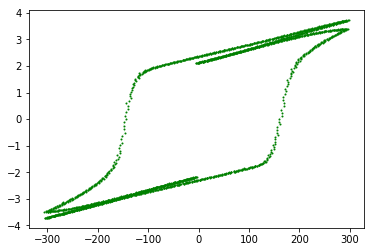

In [3]:
plt.plot(df['#Drive Voltage'], df['Measured Polarization'],'go--',linewidth=0.1, markersize=1)
plt.show()

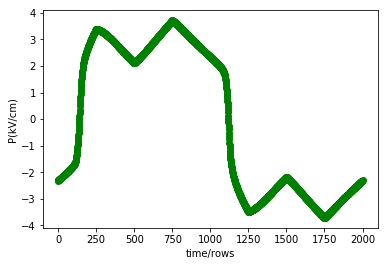

[ 251  750 1500]


In [4]:
# 提取出P值的plot,并且找到前两个peak，然后做差，即得出 delta P，which is from leakgae only
P_value = df['Measured Polarization']
# print(type(P_value))

plt.plot(P_value,'go--')
# plt.plot(-P_value,'ro--')#找到 负向电压的P的2个peak 
plt.xlabel('time/rows')
plt.ylabel('P(kV/cm)')
plt.show()
indices = find_peaks(P_value, prominence=1)[0]# find pea找到的是 【x,y】，而这里我只需要x, 所以用【0】index
print(indices)

# indices_2 = find_peaks(-P_value, prominence=1)[0]# find pea找到的是 【x,y】，而这里我只需要x, 所以用【0】index
# print(indices_2)

# df[250:260]
# 因为找到的峰不止一个，为了保险起见，我选择将图像分段，0-500和500-1000个点为区间，分别找peak

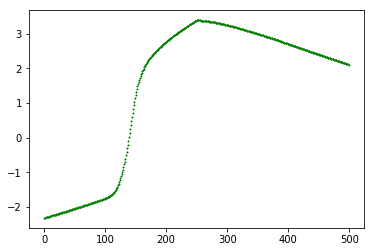

[251]


In [5]:
P_peak1 = P_value[0:500]
plt.plot(P_peak1, color='green', marker='+', linestyle='dashed',linewidth=0.1, markersize=2)
plt.show()
index1 = find_peaks(P_peak1, prominence = 1)[0]
print(index1)
# print(type(P_peak1))

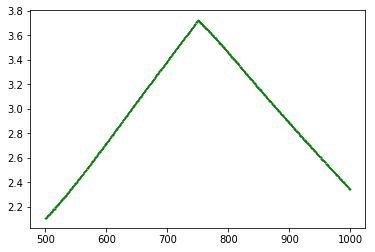

[750]


In [6]:
P_peak2 = P_value[500:1000]
plt.plot(P_peak2,color='green', marker='+', linestyle='dashed',linewidth=0.1, markersize=2)
plt.show()
index2 = find_peaks(P_peak2, prominence = 1)[0]+500  #要加上500，因为上一段有500个点
print(index2)

In [9]:
# print(type(index2))
# print(index2[0])
delta_P=df.loc[index2[0],'Measured Polarization']-df.loc[index1[0],'Measured Polarization']

print(type(delta_P))
print('delta P from R = ',delta_P, 'uC/cm2')


<class 'numpy.float64'>
delta P from R =  -0.23335099999999986 uC/cm2


# 对于 电阻而言
# I = U/R
# P = Q/Area = inte(Idt) /Area
# P = inte(U) / R* Area

# ΔP = 1/R*Area *  Δinte(U)

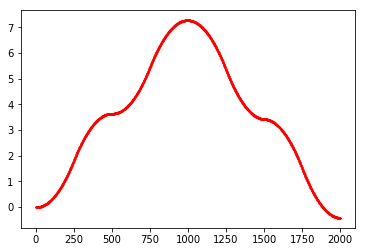

In [10]:
x = 0.001*df['Time (ms)'] # 乘 0.001 是为了把 （毫秒）变成（秒）
y = df['#Drive Voltage']
y_integration = integrate.cumtrapz(y, x, initial=0)
# print(y_integration)
plt.plot(y_integration, color='red', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
plt.show()

In [11]:
#插入voltage的积分这一列
df.insert(len(df.columns), "Voltage Integration(V*s)", y_integration)
df.head(10)

,#Drive Voltage,E_SI,Measured Polarization,P_SI,Point,Time (ms),Voltage Integration(V*s)
0,-7.0190,-7.0190,-2.314750,-0.023148,1.0,0.05,0.000000
1,-2.8229,-2.8229,-2.310897,-0.023109,2.0,0.10,-0.000246
2,3.5095,3.5095,-2.303527,-0.023035,3.0,0.15,-0.000229
3,-1.2207,-1.2207,-2.295486,-0.022955,4.0,0.20,-0.000172
4,2.6703,2.6703,-2.291298,-0.022913,5.0,0.25,-0.000135
5,3.1281,3.1281,-2.288115,-0.022881,6.0,0.30,0.000010
6,2.3651,2.3651,-2.285100,-0.022851,7.0,0.35,0.000147
7,3.6621,3.6621,-2.277226,-0.022772,8.0,0.40,0.000298
8,7.5531,7.5531,-2.274546,-0.022745,9.0,0.45,0.000578
9,6.0272,6.0272,-2.265668,-0.022657,10.0,0.50,0.000917


#  ΔP =  Δinte(U)/(R*Area )

In [12]:
#求出从peak1 到 peak2的voltage积分的差值
delta_V_integral = df.loc[index2[0],'Voltage Integration(V*s)']-df.loc[index1[0],'Voltage Integration(V*s)']
print(delta_V_integral)
one_over_AR = delta_P/delta_V_integral

# Sample area  = 2.42mm2 = 0.0242 cm2
# 1 C = 1 A * 1 S  库伦 =  安培 x 秒
resistance = (delta_V_integral)/(delta_P*0.0242*0.000001)

print(one_over_AR)
print('resistance = ', resistance,'ohm')    

-3.842950850000001
0.06072182786308594
resistance =  680518283.1906724 ohm


In [13]:
#with 1/AR, Volta_integration x 1/AR = 单纯电阻对 P 的贡献
P_fromR  = df['Voltage Integration(V*s)']*one_over_AR
# 把 P from R 的中心调到原点
P_fromR = P_fromR - 0.5*(max(P_fromR)+min(P_fromR))

df.insert(len(df.columns), "P from R", P_fromR)
df.head(10)

,#Drive Voltage,E_SI,Measured Polarization,P_SI,Point,Time (ms),Voltage Integration(V*s),P from R
0,-7.0190,-7.0190,-2.314750,-0.023148,1.0,0.05,0.000000,-0.208214
1,-2.8229,-2.8229,-2.310897,-0.023109,2.0,0.10,-0.000246,-0.208229
2,3.5095,3.5095,-2.303527,-0.023035,3.0,0.15,-0.000229,-0.208228
3,-1.2207,-1.2207,-2.295486,-0.022955,4.0,0.20,-0.000172,-0.208224
4,2.6703,2.6703,-2.291298,-0.022913,5.0,0.25,-0.000135,-0.208222
5,3.1281,3.1281,-2.288115,-0.022881,6.0,0.30,0.000010,-0.208213
6,2.3651,2.3651,-2.285100,-0.022851,7.0,0.35,0.000147,-0.208205
7,3.6621,3.6621,-2.277226,-0.022772,8.0,0.40,0.000298,-0.208196
8,7.5531,7.5531,-2.274546,-0.022745,9.0,0.45,0.000578,-0.208179
9,6.0272,6.0272,-2.265668,-0.022657,10.0,0.50,0.000917,-0.208158


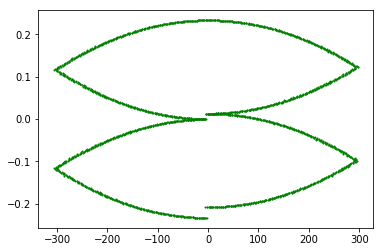

In [14]:
plt.plot(df['#Drive Voltage'], df['P from R'], color='green', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
# plt.plot(df['#Drive Voltage'], df['Corrected P'], color='red', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
# plt.plot(df['#Drive Voltage'], df['Measured Polarization'], color='blue', marker='+', linestyle='dashed',linewidth=0.1, markersize=1)
plt.show()

C:\Users\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


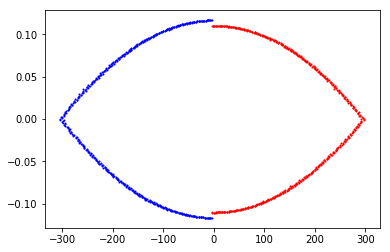

New length =  1000 (lines)


,#Drive Voltage,E_SI,Measured Polarization,P_SI,Point,Time (ms),Voltage Integration(V*s),P from R
500,-4.3488,-4.3488,2.110379,0.021104,501.0,25.05,3.641149,-0.110393
501,-4.7302,-4.7302,2.113730,0.021137,502.0,25.10,3.640923,-0.110406
502,1.2970,1.2970,2.119425,0.021194,503.0,25.15,3.640837,-0.110411
503,-0.2289,-0.2289,2.123446,0.021234,504.0,25.20,3.640863,-0.110410
504,0.3052,0.3052,2.131487,0.021315,505.0,25.25,3.640865,-0.110410


In [15]:
#剔除重叠的部分，删除500-1000行 以及 1500-2000行
# 创建了 New_dataframe 来装删除后的data
P_positivepart= df.iloc[500:1000]
P_negativepart= df.iloc[1500:2000]

#调到原点
P_positivepart['P from R'] = P_positivepart['P from R'] - 0.5*(max(P_positivepart['P from R'])+min(P_positivepart['P from R']))
P_negativepart['P from R'] = P_negativepart['P from R'] - 0.5*(max(P_negativepart['P from R'])+min(P_negativepart['P from R']))#- (df.loc[1000, 'P from R'] -df.loc[0, 'P from R'])

plt.plot(P_positivepart['#Drive Voltage'], P_positivepart['P from R'], color='red', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
plt.plot(P_negativepart['#Drive Voltage'], P_negativepart['P from R'], color='blue', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
plt.show()

# 拼接前后2个部分
New_df = P_positivepart.append(P_negativepart)
print('New length = ',len(New_df),'(lines)',)# 确认length是不是1000，删除前是2000
New_df.head(5)

In [16]:
#用测量的 P 减去 P from R，即得到 P without conduction
P_corrected =New_df['Measured Polarization']-New_df['P from R']
New_df.insert(len(df.columns), "Corrected P", P_corrected)
New_df.head(5)

,#Drive Voltage,E_SI,Measured Polarization,P_SI,Point,Time (ms),Voltage Integration(V*s),P from R,Corrected P
500,-4.3488,-4.3488,2.110379,0.021104,501.0,25.05,3.641149,-0.110393,2.220772
501,-4.7302,-4.7302,2.113730,0.021137,502.0,25.10,3.640923,-0.110406,2.224136
502,1.2970,1.2970,2.119425,0.021194,503.0,25.15,3.640837,-0.110411,2.229836
503,-0.2289,-0.2289,2.123446,0.021234,504.0,25.20,3.640863,-0.110410,2.233856
504,0.3052,0.3052,2.131487,0.021315,505.0,25.25,3.640865,-0.110410,2.241897


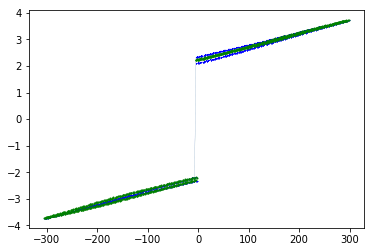

In [72]:
plt.plot(New_df['#Drive Voltage'], New_df['Measured Polarization'],'b+--',linewidth=0.1, markersize=1)
plt.plot( New_df['#Drive Voltage'],New_df['Corrected P'],'go--',linewidth=0.1, markersize=1)
# plt.axis([500,1000,2,4])
plt.show()

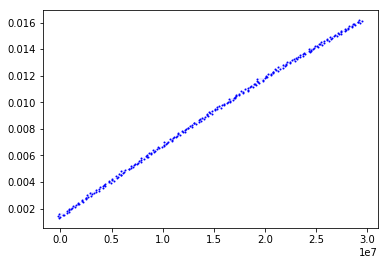

[5.03532035e-10 1.65316969e-03]
56.87057092115495


In [87]:
# linear fitting to caculate the Dielectric Donstant E1

# P = vaccumme permitivity x (dielectric constant -1) x E
x = 100000*New_df.loc[750:1000, '#Drive Voltage'] # (kV/cm) = 10^5 *(V/m)
y = 0.01*New_df.loc[750:1000, 'Corrected P']# (uC/cm2)=10^-2 *(C/m2)
coeff = np.polyfit(x,y, deg = 1) # 第一个是斜率，第二个是截距
plt.plot( x,y,'bo--',linewidth=0.1, markersize=1)
plt.show()
print(coeff)
slope = coeff[0]
dielectric_constant = slope/(8.854*0.000000000001)
print(dielectric_constant)

In [76]:
#从文件名提取温度with regular expression
path = r'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating'
files = os.listdir(path)
temperature = list()
for file in files:
    if file.endswith(".tab"):
        num = re.findall(r"\d+.\d+", file)
        temperature.append(float(num[0]))
print(temperature)

[359.93, 360.05, 360.41, 360.8, 361.17, 361.4, 361.72, 362.03, 362.38, 362.65, 363.04, 363.37, 363.62, 363.96, 364.16, 364.54, 364.75, 364.92, 365.18, 365.41, 365.69, 365.92, 366.19, 366.35, 366.65, 366.91, 367.12, 367.4, 367.63, 367.89, 368.17, 368.4, 368.64, 368.88, 369.1, 369.37, 369.61, 369.91, 370.14, 370.39, 370.58, 370.89, 371.11, 371.37, 371.62, 371.83, 372.08, 372.33, 372.6, 372.82, 373.06, 373.35, 373.53, 373.79, 374.06, 374.3, 374.57, 374.79, 375.07, 375.27, 375.55, 375.77, 376.04, 376.31, 376.47, 376.82, 377.08, 377.25, 377.52, 377.9, 378.06, 378.34, 378.62, 378.88, 379.02, 379.25, 379.64, 379.79, 380.06, 380.29, 380.54, 380.79, 381.0, 381.36, 381.54, 381.84, 381.99, 382.38, 382.46, 382.79, 383.06, 383.32, 383.51, 383.8, 384.01, 384.35, 384.43, 384.8, 384.98, 385.23, 385.44, 385.74, 385.99, 386.22, 386.5, 386.64, 386.96, 387.2, 387.53, 387.73, 387.89, 388.26, 388.44, 388.7, 388.92, 389.22, 389.4, 389.61, 389.96, 390.13, 390.43, 390.63, 390.88, 391.16, 391.39, 391.69, 391.87

In [101]:
#批量操作所有文件
path = 'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating'
# output_path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_PUND'
files = glob(path + "/*.tab")

lst_E1=list()
lst_T=list()
i = 0

for file in files:
    df = pd.read_csv(file,delimiter='\t',encoding= 'unicode_escape')
    P_value = df['Measured Polarization']
    P_peak1 = P_value[0:500]
    index1 = find_peaks(P_peak1, prominence = 1)[0]
    P_peak2 = P_value[500:1000]
    index2 = find_peaks(P_peak2, prominence = 1)[0]+500

    ##插入voltage 积分
    x = 0.001*df['Time (ms)']
    y = df['#Drive Voltage']
    y_integration = integrate.cumtrapz(y, x, initial=0)
    df.insert(len(df.columns), "Voltage Integration", y_integration)
    ##计算 V inte, R, 1/Area*R
    delta_V_integral = df.ix[index2[0],'Voltage Integration']-df.ix[index1[0],'Voltage Integration']
    delta_P=df.ix[index2[0],'Measured Polarization']-df.ix[index1[0],'Measured Polarization'] 
    one_over_AR = delta_P/delta_V_integral
    
    #计算P from R 然后 Centering
    P_fromR  = df['Voltage Integration']*one_over_AR
    P_fromR = P_fromR - 0.5*(max(P_fromR)+min(P_fromR))
    df.insert(len(df.columns), "P from R", P_fromR)
    
    #剔除重叠的部分，删除500-1000行 以及 1500-2000行
    P_positivepart= df.iloc[500:1000]
    P_negativepart= df.iloc[1500:2000]
    
    #调到原点
    P_positivepart['P from R'] = P_positivepart['P from R'] - 0.5*(max(P_positivepart['P from R'])+min(P_positivepart['P from R']))
    P_negativepart['P from R'] = P_negativepart['P from R'] - 0.5*(max(P_negativepart['P from R'])+min(P_negativepart['P from R']))#- (df.loc[1000, 'P from R'] -df.loc[0, 'P from R'])
    
    #创建了 New_dataframe 来装删除后的data
    New_df = P_positivepart.append(P_negativepart)
    
    #计算corrected P
    P_corrected =New_df['Measured Polarization']-New_df['P from R']
    New_df.insert(len(df.columns), "Corrected P", P_corrected)
    
    x = 100000*New_df.loc[509:750, '#Drive Voltage'] # (kV/cm) = 10^5 *(V/m)
    y = 0.01*New_df.loc[500:750, 'Corrected P']# (uC/cm2)=10^-2 *(C/m2)
    coeff = np.polyfit(x,y, deg = 1) # 第一个是斜率，第二个是截距
    slope = coeff[0]
    dielectric_constant = slope/(8.854*0.000000000001)

    
    #输出center后的 dataframe
#     file_name = output_path +'\\'+ str(temperature[i])+'.csv'
#     Centerred_df.to_csv(file_name, index=None)
    
    #记录每个PE loop的 resistance value
    lst_E1.append(dielectric_constant)
    lst_T.append(temperature[i])
    i = i+1
    
    
# print(lst_AR)
# print(lst_T)
# print(lst_Pshift)

#将list转化成dictionary，然后转化成DataFrame
dic={"Dielectric constant":lst_E1,
  "T":lst_T}
dt=pd.DataFrame(dic)


C:\Users\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   Dielectric constant       T
0            50.517257  359.93
1            55.693549  360.05
2            51.346956  360.41


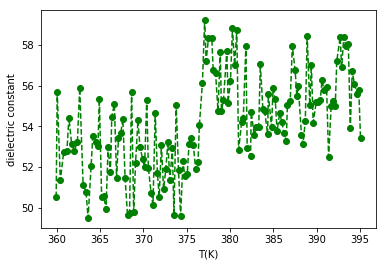

In [97]:
#500:750
print(dt.head(3))
plt.figure()
plt.plot(dt['T'],dt['Dielectric constant'],'go--')
plt.xlabel('T(K)')
plt.ylabel('dielectric constant')
plt.ticklabel_format(style='sci', axis='y')
# plt.axis([377,395,0,1600000000])

plt.show()

   Dielectric constant       T
0            47.421629  359.93
1            52.554610  360.05
2            48.051222  360.41


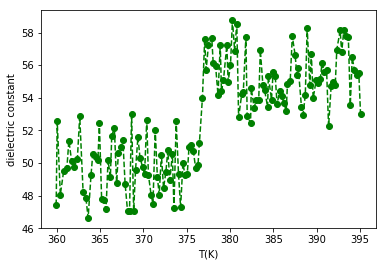

In [99]:
#1500:1750
print(dt.head(3))
plt.figure()
plt.plot(dt['T'],dt['Dielectric constant'],'go--')
plt.xlabel('T(K)')
plt.ylabel('dielectric constant')
plt.ticklabel_format(style='sci', axis='y')
# plt.axis([377,395,0,1600000000])

plt.show()

   Dielectric constant       T
0            61.346667  359.93
1            60.171787  360.05
2            62.658218  360.41


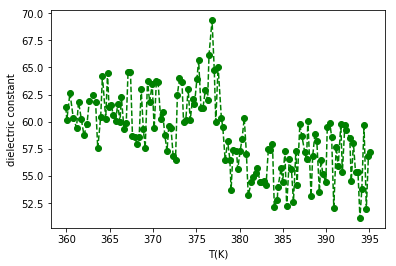

In [102]:
#1750:2000
print(dt.head(3))
plt.figure()
plt.plot(dt['T'],dt['Dielectric constant'],'go--')
plt.xlabel('T(K)')
plt.ylabel('dielectric constant')
plt.ticklabel_format(style='sci', axis='y')
# plt.axis([377,395,0,1600000000])

plt.show()